# Define similarity measures

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import jaccard_score as jaccard_similarity


def dot_similarity(vector1, vector2):
    return np.sum(np.multiply(np.array(vector1), np.array(vector2)))

def cosine_similarity(vector1, vector2):
    return dot_similarity(vector1, vector2) / np.sqrt(np.sum(vector1)**2 * np.sum(vector2)**2)

# Data tokenization

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
# ‘english’
def get_boolean_representation(corpus, stop_words_list='english'):
    vectorizer = CountVectorizer(binary=True, stop_words=stop_words_list)
    X = vectorizer.fit_transform(corpus)
    vectorizer.get_feature_names_out()
    return X.toarray()

def get_tf_representation(corpus, stop_words_list='english'):
    vectorizer = CountVectorizer(binary=False, stop_words=stop_words_list)
    X = vectorizer.fit_transform(corpus)
    vectorizer.get_feature_names_out()
    return X.toarray()

def get_tf_idf_representation(corpus, stop_words_list='english'):
    vectorizer = TfidfVectorizer(stop_words=stop_words_list)
    X = vectorizer.fit_transform(corpus)
    vectorizer.get_feature_names_out()
    return X.toarray()

# Define functions for centroid classification

In [3]:
class centroids_model:
    centroids_0 = None
    centroids_1 = None

    def get_centroids(self):
        if self.centroids_0 is None or self.centroids_1 is None :
            print('Error : class must be fitted before')
            exit(-1)
        else:
            return self.centroids_0, self.centroids_1

    def fit(self, data, labels):
        index_label_0 = np.argwhere(np.array(labels) == 0).reshape(-1)
        index_label_1 = np.argwhere(np.array(labels) == 1).reshape(-1)

        # compute centroids
        self.centroids_0 = np.sum(data[index_label_0], axis=0) / len(index_label_0)
        self.centroids_1 = np.sum(data[index_label_1], axis=0) / len(index_label_1)


    def predict(self, data, similarity='cosine'):
        if self.centroids_0 is None or self.centroids_1 is None :
            print('Error : class must be fitted before prediction')
            exit(-1)
        if similarity == 'dot':
            return [1 if dot_similarity(entry, self.centroids_0) < dot_similarity(entry, self.centroids_1) else 0 for entry in data]
        # elif similarity == 'jaccard':
        #     return [1 if jaccard_similarity(entry, self.centroids_0) < jaccard_similarity(entry, self.centroids_1) else 0 for entry in data]
        else:
            return [1 if cosine_similarity(entry, self.centroids_0) < cosine_similarity(entry, self.centroids_1) else 0  for entry in data]

# Experiments for kNN classification

In [4]:
import pandas as pd

df_train = pd.read_csv("../data/DataFrame_train_PREPROCESS.csv")
df_val = pd.read_csv("../data/DataFrame_val_PREPROCESS.csv")

index_train = df_train['index']
index_val = df_val['index']

df = pd.concat([df_train, df_val], ignore_index = True, sort = False)


representation_boolean = get_boolean_representation(df['text'].apply(lambda x : x.lower()))
representation_tf = get_tf_representation(df['text'].apply(lambda x : x.lower()))
representation_tf_idf = get_tf_idf_representation(df['text'].apply(lambda x : x.lower()))

del df

x_train_boolean = representation_boolean[:len(index_train)]
x_val_boolean = representation_boolean[len(index_train):]

x_train_tf = representation_tf[:len(index_train)]
x_val_tf = representation_tf[len(index_train):]

x_train_tf_idf = representation_tf_idf[:len(index_train)]
x_val_tf_idf = representation_tf_idf[len(index_train):]


y_train = df_train['label']
y_val = df_val['label']

del df_val
del df_train

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

results_boolean = pd.DataFrame(columns=['k', 'acc', 'aucroc'])
results_tf = pd.DataFrame(columns=['k', 'acc', 'aucroc'])
results_tf_idf = pd.DataFrame(columns=['k', 'acc', 'aucroc'])

for k in range(1, 7):
    print('**',k,'**','\n')
    kNN = KNeighborsClassifier(n_neighbors=k)
    kNN.fit(x_train_boolean, y_train)
    y_predict = kNN.predict(x_val_boolean)
    results_boolean = results_boolean.append(pd.DataFrame({'k':[k],'acc':[accuracy_score(y_val, y_predict)],'aucroc':[roc_auc_score(y_val, y_predict)]}))

    print('TF representation')
    kNN = KNeighborsClassifier(n_neighbors=k)
    kNN.fit(x_train_tf, y_train)
    y_predict = kNN.predict(x_val_tf)
    results_tf = results_tf.append(pd.DataFrame({'k':[k],'acc':[accuracy_score(y_val, y_predict)],'aucroc':[roc_auc_score(y_val, y_predict)]}))

    print('TF-IDF representation')
    kNN = KNeighborsClassifier(n_neighbors=k)
    kNN.fit(x_train_tf_idf, y_train)
    y_predict = kNN.predict(x_val_tf_idf)
    results_tf_idf = results_tf_idf.append(pd.DataFrame({'k':[k],'acc':[accuracy_score(y_val, y_predict)],'aucroc':[roc_auc_score(y_val, y_predict)]}))

** 1 ** 

TF representation
TF-IDF representation
** 2 ** 

TF representation
TF-IDF representation
** 3 ** 

TF representation
TF-IDF representation
** 4 ** 

TF representation
TF-IDF representation
** 5 ** 

TF representation
TF-IDF representation
** 6 ** 

TF representation
TF-IDF representation


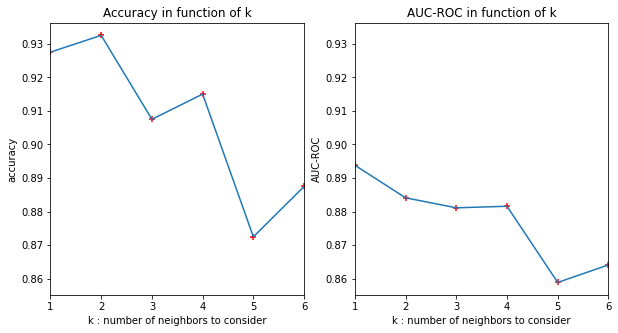

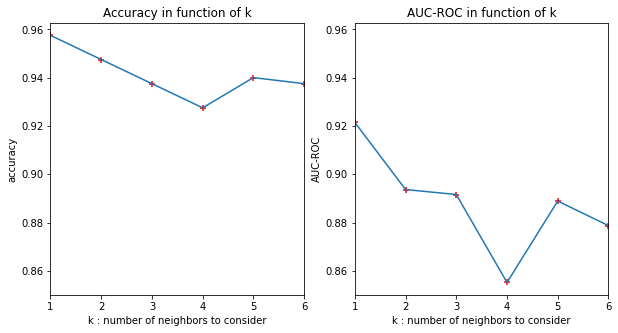

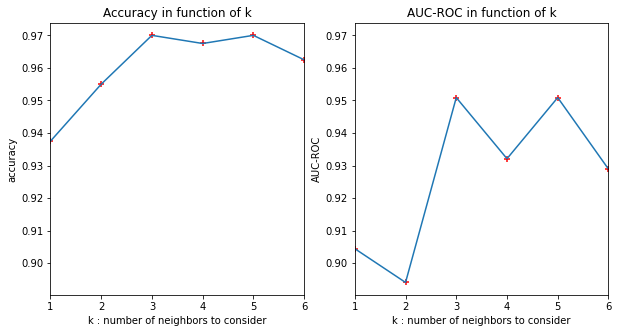

In [11]:
import matplotlib.pyplot as plt

z = 0
filename = ['knn_boolean_repr.png', 'knn_tf_repr.png', 'knn_tf_idf_repr.png']
for df in [results_boolean, results_tf, results_tf_idf]:
    fig = plt.figure(figsize=(10,5))

    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)

    x, y = df['k'], df['acc']
    ax1.plot(x, y)
    ax1.scatter(x, y, c='red', marker='+')
    ax1.set_title("Accuracy in function of k")
    ax1.set_xlim([1,6])
    ax1.set_xlabel("k : number of neighbors to consider")
    ax1.set_ylabel("accuracy")

    x, y = df['k'], df['aucroc']
    ax2.plot(x, y)
    ax2.scatter(x, y, c='red', marker='+')
    ax2.set_title("AUC-ROC in function of k")
    ax2.set_xlim([1,6])
    ax2.set_xlabel("k : number of neighbors to consider")
    ax2.set_ylabel("AUC-ROC")

    plt.show()
    fig.savefig(fname=filename[z])
    z += 1

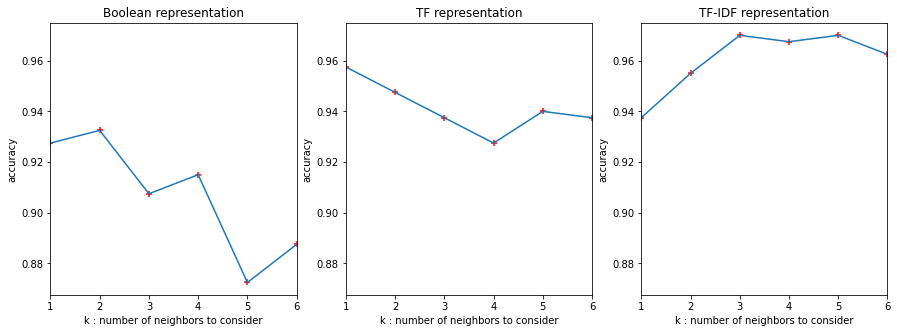

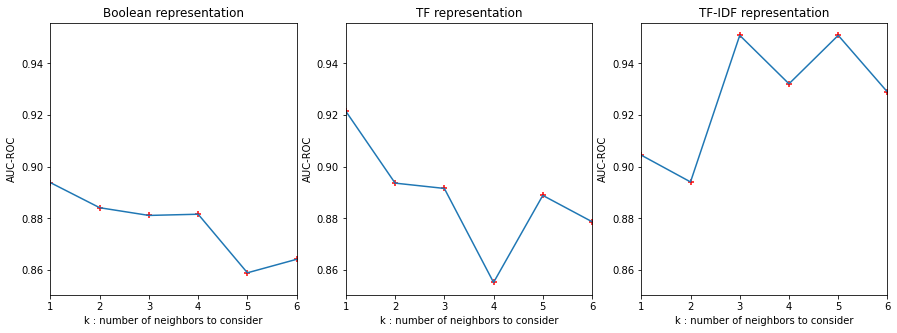

In [13]:
import matplotlib.pyplot as plt

z = 0
filename = ['knn_accuracy.png', 'knn_auc_roc.png']
# [results_boolean, results_tf, results_tf_idf]
for metric in ['acc', 'aucroc']:
    fig = plt.figure(figsize=(15,5))

    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2, sharey=ax1)
    ax3 = fig.add_subplot(1, 3, 3, sharey=ax1)

    x, y = results_boolean['k'], results_boolean[metric]
    ax1.plot(x, y)
    ax1.scatter(x, y, c='red', marker='+')
    if metric == 'acc':
        ax1.set_ylabel("accuracy")
    else:
        ax1.set_ylabel("AUC-ROC")
    ax1.set_title("Boolean representation")
    ax1.set_xlabel("k : number of neighbors to consider")
    ax1.set_xlim([1,6])


    x, y = results_tf['k'], results_tf[metric]
    ax2.plot(x, y)
    ax2.scatter(x, y, c='red', marker='+')
    if metric == 'acc':
        ax2.set_ylabel("accuracy")
    else:
        ax2.set_ylabel("AUC-ROC")
    ax2.set_title("TF representation")
    ax2.set_xlabel("k : number of neighbors to consider")
    ax2.set_xlim([1,6])

    x, y = results_tf_idf['k'], results_tf_idf[metric]
    ax3.plot(x, y)
    ax3.scatter(x, y, c='red', marker='+')
    if metric == 'acc':
        ax3.set_ylabel("accuracy")
    else:
        ax3.set_ylabel("AUC-ROC")
    ax3.set_title("TF-IDF representation")
    ax3.set_xlabel("k : number of neighbors to consider")
    ax3.set_xlim([1,6])

    plt.show()
    fig.savefig(fname=filename[z])
    z += 1